In [197]:
import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from typing import List

## Read data

In [207]:
def read_file(file_name: str) -> list:
    with open(file_name) as file:
         return [word.lower() for line in file for word in re.findall(r'\w+', line)]

In [208]:
data = read_file(file_name= 'data.txt')

## Matrix factorization

In [209]:
class MatrixFactorization(object):

    def __init__(self, matrix: np.ndarray):
        self.__matrix = matrix
        
    def train(self,
              desired_dimensions: int,
              alpha: float= 1e-2,
              beta: float= 1e-2,
              epsilon: float= 1e-5,
              iterations: int= 1e3,
              auto_adjust_initial_values: bool= True):
        self.U = np.random.rand(self.__matrix.shape[0], desired_dimensions)
        self.V = np.random.rand(self.__matrix.shape[1], desired_dimensions)
        self.b = np.zeros(self.__matrix.shape)
        
        if auto_adjust_initial_values:
            mean = np.mean(self.__matrix)
            self.U *= mean
            self.V *= mean
            self.b *= mean
        
        return self.__gradient_descent(alpha, beta, epsilon, iterations)
       
    def get_predicted_matrix(self):
        return self.U@self.V.T + self.b
    
    def get_vector(self, line: int, column: int) -> np.ndarray:
        return self.U[line] * self.V[column] + self.b[line, column]

    def __gradient_descent(self, alpha, beta, epsilon, iterations) -> np.ndarray:
        current_step = 0
        errors = []
        while True:
            error = self.__matrix - self.get_predicted_matrix()
            old_U = self.U.copy()
            
            self.b += alpha * (error - beta * self.b)
            
            self.U += alpha * (error @ self.V - beta * self.U)
            self.V += alpha * (error.T @ old_U - beta * self.V)
            errors.append(self.__compute_mean_squared_error())
            current_step += 1
            
            if np.linalg.norm(self.U - old_U) < epsilon or current_step > iterations:
                return {
                    'errors' : errors,
                    'iterations' : current_step
                }
    
    def __compute_mean_squared_error(self) -> np.ndarray:
        return np.mean((self.__matrix - self.get_predicted_matrix()) ** 2)

## Word embedding

In [219]:
class WordEmbedding(object):
    
    def __init__(self, data: List[str]):
        self.__data = data
        
    def train(self,
              window_size,
              desired_dimensions: int,
              alpha: float= 1e-2 ,
              beta: float= 1e-2,
              epsilon: float= 1e-5,
              iterations: int= 1e3,
              auto_adjust_initial_values: bool= True):
        
        self.co_occurrence_matrix = self.__build_co_occurrence_matrix(window_size)
        self.probability_matrix = self.__build_probability_matrix()
        self.__matrix_factorization = MatrixFactorization(matrix= self.probability_matrix)
        training_result = self.__matrix_factorization.train(desired_dimensions, alpha, beta, epsilon, iterations)
        self.__embeddings = self.__matrix_factorization.U * self.__matrix_factorization.V
        self.b = self.__matrix_factorization.b
        return training_result
        
    def get_predicted_matrix(self) -> np.ndarray:
        return self.__matrix_factorization.get_predicted_matrix()
    
    def get_embeddings(self) -> np.ndarray:
        return self.__embeddings
    
    def get_words(self) -> np.ndarray:
        return self.__words
        
    def __build_co_occurrence_matrix(self, window_size = (10, 10)) -> np.ndarray:
        self.__words = list(set(self.__data))
        number_of_words = len(self.__words)
        vocab = {word:index for index, word in enumerate(self.__words)}
        number_data = np.array([vocab[word] for word in self.__data])
        
        indices = np.arange(len(number_data))[window_size[0]:-window_size[1]].reshape(-1, 1)
        window = np.concatenate((np.arange(start= -window_size[0], stop= 0, step= 1),
                            np.arange(start= 1, stop= window_size[1] + 1, step= 1)))
        co_occurrence_matrix = np.ones(shape= (number_of_words, number_of_words), dtype= np.float)
        co_occurrence_matrix[number_data[indices], number_data[indices + window]] += 1/np.abs(window)
        
        return co_occurrence_matrix
        
    def __build_probability_matrix(self) -> np.ndarray:
        return self.co_occurrence_matrix / np.sum(self.co_occurrence_matrix, axis= 1, keepdims= True)

In [225]:
embeddings = WordEmbedding(data)

In [226]:
embeddings.train(window_size= (2, 2), desired_dimensions= 100)

{'errors': [3.6753004294014294e-05,
  3.575961911323954e-05,
  3.478924017161241e-05,
  3.384145455442862e-05,
  3.291585443866902e-05,
  3.2012036994549525e-05,
  3.1129604294289616e-05,
  3.0268163227824874e-05,
  2.9427325425183296e-05,
  2.8606707185240977e-05,
  2.7805929410568915e-05,
  2.702461754807973e-05,
  2.6262401535181146e-05,
  2.5518915751141443e-05,
  2.4793798973371812e-05,
  2.4086694338330517e-05,
  2.3397249306754917e-05,
  2.272511563292908e-05,
  2.2069949337697244e-05,
  2.1431410684936486e-05,
  2.080916416120607e-05,
  2.0202878458295263e-05,
  1.961222645839691e-05,
  1.9036885221639564e-05,
  1.8476535975717683e-05,
  1.793086410736616e-05,
  1.73995591554328e-05,
  1.6882314805310582e-05,
  1.6378828884499488e-05,
  1.5888803359076525e-05,
  1.5411944330861702e-05,
  1.4947962035076735e-05,
  1.4496570838303182e-05,
  1.4057489236556057e-05,
  1.3630439853299306e-05,
  1.3215149437239221e-05,
  1.281134885974223e-05,
  1.2418773111733547e-05,
  1.2037161299

In [227]:
res = embeddings.get_embeddings()
res_norm = (res - np.min(res))/ (np.max(res) - np.min(res))

In [230]:
pca = PCA(n_components=3) #2-dimensional PCA
transformed = pca.fit_transform(res_norm)

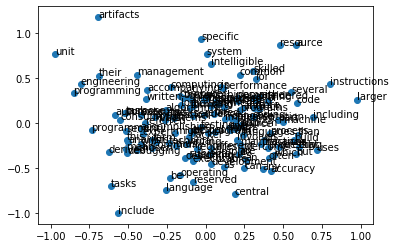

In [231]:
fig, ax = plt.subplots()
x = transformed[:, 0]
y = transformed[:, 1]
words = embeddings.get_words()
ax.scatter(x, y)

for i, word in enumerate(words):
    ax.annotate(word, (x[i], y[i]))
plt.show()